In [ ]:
!pip install torch==1.13.0 omegaconf albumentations==0.4.3 opencv-python pudb==2019.2 imageio==2.9.0 imageio-ffmpeg==0.4.2 pytorch-lightning==1.4.2 omegaconf==2.1.1 test-tube>=0.7.5 streamlit>=0.73.1 einops==0.3.0 torch-fidelity==0.3.0 git+https://github.com/openai/CLIP.git protobuf~=3.20.1 torchmetrics==0.6.0 transformers==4.19.2 kornia==0.5.8
!pip install --upgrade einops

%cd /content
!git clone https://github.com/gligen/GLIGEN.git
!git clone https://github.com/CompVis/latent-diffusion.git
%cd /content/latent-diffusion
!pip install -q -e .


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-myylrkj8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 1.13.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.13.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.13.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: einops
    Found existing installation: einops 0.3.0
    Uninstalling einops-0.3.0:
      Successfully uninstalled einops-0.3.0
/content
Cloning into 'GLIGEN'...
remote: Enumerating objects: 476, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 476 (delta 94), re

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
%cd /content/GLIGEN
!mkdir gligen_checkpoints
%cd /content/GLIGEN/gligen_checkpoints
if not os.path.exists('checkpoint_generation_keypoint.pth'):
  !git clone https://huggingface.co/gligen/gligen-generation-keypoint
  !mv gligen-generation-keypoint/diffusion_pytorch_model.bin gligen-generation-keypoint/checkpoint_generation_keypoint.pth
  !mv gligen-generation-keypoint/checkpoint_generation_keypoint.pth checkpoint_generation_keypoint.pth
else:
  print('Checkpoints were already loaded')

/content/GLIGEN
/content/GLIGEN/gligen_checkpoints
Cloning into 'gligen-generation-keypoint'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Unpacking objects: 100% (6/6), 798 bytes | 798.00 KiB/s, done.
Encountered 1 file(s) that may not have been copied correctly on Windows:
	diffusion_pytorch_model.bin

See: `git lfs help smudge` for more details.


In [ ]:
# Go back to GLIGEN folder
%cd /content/GLIGEN

/content/GLIGEN


In [ ]:
import argparse
from PIL import Image, ImageDraw
from omegaconf import OmegaConf
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from transformers import CLIPProcessor, CLIPModel
from copy import deepcopy
import torch
from ldm.util import instantiate_from_config
from inpaint_mask_func import draw_masks_from_boxes
from trainer import read_official_ckpt, batch_to_device
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import random
import clip
from scipy.io import loadmat
from functools import partial
import torchvision.transforms.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

device = "cuda"

In [ ]:
def set_alpha_scale(model, alpha_scale):
    from ldm.modules.attention import GatedCrossAttentionDense, GatedSelfAttentionDense
    for module in model.modules():
        if type(module) == GatedCrossAttentionDense or type(module) == GatedSelfAttentionDense:
            module.scale = alpha_scale


def alpha_generator(length, type=None):
    """
    length is total timestpes needed for sampling.
    type should be a list containing three values which sum should be 1

    It means the percentage of three stages:
    alpha=1 stage
    linear deacy stage
    alpha=0 stage.

    For example if length=100, type=[0.8,0.1,0.1]
    then the first 800 stpes, alpha will be 1, and then linearly decay to 0 in the next 100 steps,
    and the last 100 stpes are 0.
    """
    if type == None:
        type = [1,0,0]

    assert len(type)==3
    assert type[0] + type[1] + type[2] == 1

    stage0_length = int(type[0]*length)
    stage1_length = int(type[1]*length)
    stage2_length = length - stage0_length - stage1_length

    if stage1_length != 0:
        decay_alphas = np.arange(start=0, stop=1, step=1/stage1_length)[::-1]
        decay_alphas = list(decay_alphas)
    else:
        decay_alphas = []


    alphas = [1]*stage0_length + decay_alphas + [0]*stage2_length

    assert len(alphas) == length

    return alphas



def load_ckpt(ckpt_path):

    saved_ckpt = torch.load(ckpt_path)
    config = saved_ckpt["config_dict"]["_content"]

    model = instantiate_from_config(config['model']).to(device).eval()
    autoencoder = instantiate_from_config(config['autoencoder']).to(device).eval()
    text_encoder = instantiate_from_config(config['text_encoder']).to(device).eval()
    diffusion = instantiate_from_config(config['diffusion']).to(device)

    # donot need to load official_ckpt for self.model here, since we will load from our ckpt
    model.load_state_dict( saved_ckpt['model'] )
    autoencoder.load_state_dict( saved_ckpt["autoencoder"]  )
    text_encoder.load_state_dict( saved_ckpt["text_encoder"]  )
    diffusion.load_state_dict( saved_ckpt["diffusion"]  )

    return model, autoencoder, text_encoder, diffusion, config




def project(x, projection_matrix):
    """
    x (Batch*768) should be the penultimate feature of CLIP (before projection)
    projection_matrix (768*768) is the CLIP projection matrix, which should be weight.data of Linear layer
    defined in CLIP (out_dim, in_dim), thus we need to apply transpose below.
    this function will return the CLIP feature (without normalziation)
    """
    return x@torch.transpose(projection_matrix, 0, 1)


def get_clip_feature(model, processor, input, is_image=False):
    which_layer_text = 'before'
    which_layer_image = 'after_reproject'

    if is_image:
        if input == None:
            return None
        image = Image.open(input).convert("RGB")
        inputs = processor(images=[image],  return_tensors="pt", padding=True)
        inputs['pixel_values'] = inputs['pixel_values'].cuda() # we use our own preprocessing without center_crop
        inputs['input_ids'] = torch.tensor([[0,1,2,3]]).cuda()  # placeholder
        outputs = model(**inputs)
        feature = outputs.image_embeds
        if which_layer_image == 'after_reproject':
            feature = project( feature, torch.load('projection_matrix').cuda().T ).squeeze(0)
            feature = ( feature / feature.norm() )  * 28.7
            feature = feature.unsqueeze(0)
    else:
        if input == None:
            return None
        inputs = processor(text=input,  return_tensors="pt", padding=True)
        inputs['input_ids'] = inputs['input_ids'].cuda()
        inputs['pixel_values'] = torch.ones(1,3,224,224).cuda() # placeholder
        inputs['attention_mask'] = inputs['attention_mask'].cuda()
        outputs = model(**inputs)
        if which_layer_text == 'before':
            feature = outputs.text_model_output.pooler_output
    return feature


def complete_mask(has_mask, max_objs):
    mask = torch.ones(1,max_objs)
    if has_mask == None:
        return mask

    if type(has_mask) == int or type(has_mask) == float:
        return mask * has_mask
    else:
        for idx, value in enumerate(has_mask):
            mask[0,idx] = value
        return mask



@torch.no_grad()
def prepare_batch(meta, batch=1, max_objs=30):
    phrases, images = meta.get("phrases"), meta.get("images")
    images = [None]*len(phrases) if images==None else images
    phrases = [None]*len(images) if phrases==None else phrases

    version = "openai/clip-vit-large-patch14"
    model = CLIPModel.from_pretrained(version).cuda()
    processor = CLIPProcessor.from_pretrained(version)

    boxes = torch.zeros(max_objs, 4)
    masks = torch.zeros(max_objs)
    text_masks = torch.zeros(max_objs)
    image_masks = torch.zeros(max_objs)
    text_embeddings = torch.zeros(max_objs, 768)
    image_embeddings = torch.zeros(max_objs, 768)

    text_features = []
    image_features = []
    for phrase, image in zip(phrases,images):
        text_features.append(  get_clip_feature(model, processor, phrase, is_image=False) )
        image_features.append( get_clip_feature(model, processor, image,  is_image=True) )

    for idx, (box, text_feature, image_feature) in enumerate(zip( meta['locations'], text_features, image_features)):
        boxes[idx] = torch.tensor(box)
        masks[idx] = 1
        if text_feature is not None:
            text_embeddings[idx] = text_feature
            text_masks[idx] = 1
        if image_feature is not None:
            image_embeddings[idx] = image_feature
            image_masks[idx] = 1

    out = {
        "boxes" : boxes.unsqueeze(0).repeat(batch,1,1),
        "masks" : masks.unsqueeze(0).repeat(batch,1),
        "text_masks" : text_masks.unsqueeze(0).repeat(batch,1)*complete_mask( meta.get("text_mask"), max_objs ),
        "image_masks" : image_masks.unsqueeze(0).repeat(batch,1)*complete_mask( meta.get("image_mask"), max_objs ),
        "text_embeddings"  : text_embeddings.unsqueeze(0).repeat(batch,1,1),
        "image_embeddings" : image_embeddings.unsqueeze(0).repeat(batch,1,1)
    }

    return batch_to_device(out, device)


def crop_and_resize(image):
    crop_size = min(image.size)
    image = TF.center_crop(image, crop_size)
    image = image.resize( (512, 512) )
    return image



@torch.no_grad()
def prepare_batch_kp(meta, batch=1, max_persons_per_image=8):

    points = torch.zeros(max_persons_per_image*17,2)
    idx = 0
    for this_person_kp in meta["locations"]:
        for kp in this_person_kp:
            points[idx,0] = kp[0]
            points[idx,1] = kp[1]
            idx += 1

    # derive masks from points
    masks = (points.mean(dim=1)!=0) * 1
    masks = masks.float()

    out = {
        "points" : points.unsqueeze(0).repeat(batch,1,1),
        "masks" : masks.unsqueeze(0).repeat(batch,1),
    }

    return batch_to_device(out, device)


@torch.no_grad()
def prepare_batch_hed(meta, batch=1):

    pil_to_tensor = transforms.PILToTensor()

    hed_edge = Image.open(meta['hed_image']).convert("RGB")
    hed_edge = crop_and_resize(hed_edge)
    hed_edge = ( pil_to_tensor(hed_edge).float()/255 - 0.5 ) / 0.5

    out = {
        "hed_edge" : hed_edge.unsqueeze(0).repeat(batch,1,1,1),
        "mask" : torch.ones(batch,1),
    }
    return batch_to_device(out, device)


@torch.no_grad()
def prepare_batch_canny(meta, batch=1):
    """
    The canny edge is very sensitive since I set a fixed canny hyperparamters;
    Try to use the same setting to get edge

    img = cv.imread(args.image_path, cv.IMREAD_GRAYSCALE)
    edges = cv.Canny(img,100,200)
    edges = PIL.Image.fromarray(edges)

    """

    pil_to_tensor = transforms.PILToTensor()

    canny_edge = Image.open(meta['canny_image']).convert("RGB")
    canny_edge = crop_and_resize(canny_edge)

    canny_edge = ( pil_to_tensor(canny_edge).float()/255 - 0.5 ) / 0.5

    out = {
        "canny_edge" : canny_edge.unsqueeze(0).repeat(batch,1,1,1),
        "mask" : torch.ones(batch,1),
    }
    return batch_to_device(out, device)


@torch.no_grad()
def prepare_batch_depth(meta, batch=1):

    pil_to_tensor = transforms.PILToTensor()

    depth = Image.open(meta['depth']).convert("RGB")
    depth = crop_and_resize(depth)
    depth = ( pil_to_tensor(depth).float()/255 - 0.5 ) / 0.5

    out = {
        "depth" : depth.unsqueeze(0).repeat(batch,1,1,1),
        "mask" : torch.ones(batch,1),
    }
    return batch_to_device(out, device)



@torch.no_grad()
def prepare_batch_normal(meta, batch=1):
    """
    We only train normal model on the DIODE dataset which only has a few scene.

    """

    pil_to_tensor = transforms.PILToTensor()

    normal = Image.open(meta['normal']).convert("RGB")
    normal = crop_and_resize(normal)
    normal = ( pil_to_tensor(normal).float()/255 - 0.5 ) / 0.5

    out = {
        "normal" : normal.unsqueeze(0).repeat(batch,1,1,1),
        "mask" : torch.ones(batch,1),
    }
    return batch_to_device(out, device)





def colorEncode(labelmap, colors):
    labelmap = labelmap.astype('int')
    labelmap_rgb = np.zeros((labelmap.shape[0], labelmap.shape[1], 3),
                            dtype=np.uint8)

    for label in np.unique(labelmap):
        if label < 0:
            continue
        labelmap_rgb += (labelmap == label)[:, :, np.newaxis] * \
            np.tile(colors[label],
                    (labelmap.shape[0], labelmap.shape[1], 1))

    return labelmap_rgb

@torch.no_grad()
def prepare_batch_sem(meta, batch=1):

    pil_to_tensor = transforms.PILToTensor()

    sem = Image.open( meta['sem']  ).convert("L") # semantic class index 0,1,2,3,4 in uint8 representation
    sem = TF.center_crop(sem, min(sem.size))
    sem = sem.resize( (512, 512), Image.NEAREST ) # acorrding to official, it is nearest by default, but I don't know why it can prodice new values if not specify explicitly
    try:
        sem_color = colorEncode(np.array(sem), loadmat('color150.mat')['colors'])
        Image.fromarray(sem_color).save("sem_vis.png")
    except:
        pass
    sem = pil_to_tensor(sem)[0,:,:]
    input_label = torch.zeros(152, 512, 512)
    sem = input_label.scatter_(0, sem.long().unsqueeze(0), 1.0)

    out = {
        "sem" : sem.unsqueeze(0).repeat(batch,1,1,1),
        "mask" : torch.ones(batch,1),
    }
    return batch_to_device(out, device)



@torch.no_grad()
def run(meta, config, starting_noise=None):

    # - - - - - prepare models - - - - - #
    model, autoencoder, text_encoder, diffusion, config = load_ckpt(meta["ckpt"])

    grounding_tokenizer_input = instantiate_from_config(config['grounding_tokenizer_input'])
    model.grounding_tokenizer_input = grounding_tokenizer_input

    grounding_downsampler_input = None
    if "grounding_downsampler_input" in config:
        grounding_downsampler_input = instantiate_from_config(config['grounding_downsampler_input'])



    # - - - - - update config from args - - - - - #
    config.update( vars(args) )
    config = OmegaConf.create(config)


    # - - - - - prepare batch - - - - - #
    if "keypoint" in meta["ckpt"]:
        batch = prepare_batch_kp(meta, config.batch_size)
    elif "hed" in meta["ckpt"]:
        batch = prepare_batch_hed(meta, config.batch_size)
    elif "canny" in meta["ckpt"]:
        batch = prepare_batch_canny(meta, config.batch_size)
    elif "depth" in meta["ckpt"]:
        batch = prepare_batch_depth(meta, config.batch_size)
    elif "normal" in meta["ckpt"]:
        batch = prepare_batch_normal(meta, config.batch_size)
    elif "sem" in meta["ckpt"]:
        batch = prepare_batch_sem(meta, config.batch_size)
    else:
        batch = prepare_batch(meta, config.batch_size)
    context = text_encoder.encode(  [meta["prompt"]]*config.batch_size  )
    uc = text_encoder.encode( config.batch_size*[""] )
    if args.negative_prompt is not None:
        uc = text_encoder.encode( config.batch_size*[args.negative_prompt] )


    # - - - - - sampler - - - - - #
    alpha_generator_func = partial(alpha_generator, type=meta.get("alpha_type"))
    if config.no_plms:
        sampler = DDIMSampler(diffusion, model, alpha_generator_func=alpha_generator_func, set_alpha_scale=set_alpha_scale)
        steps = 250
    else:
        sampler = PLMSSampler(diffusion, model, alpha_generator_func=alpha_generator_func, set_alpha_scale=set_alpha_scale)
        steps = 50


    # - - - - - inpainting related - - - - - #
    inpainting_mask = z0 = None  # used for replacing known region in diffusion process
    inpainting_extra_input = None # used as model input
    if "input_image" in meta:
        # inpaint mode
        assert config.inpaint_mode, 'input_image is given, the ckpt must be the inpaint model, are you using the correct ckpt?'

        inpainting_mask = draw_masks_from_boxes( batch['boxes'], model.image_size  ).cuda()

        input_image = F.pil_to_tensor( Image.open(meta["input_image"]).convert("RGB").resize((512,512)) )
        input_image = ( input_image.float().unsqueeze(0).cuda() / 255 - 0.5 ) / 0.5
        z0 = autoencoder.encode( input_image )

        masked_z = z0*inpainting_mask
        inpainting_extra_input = torch.cat([masked_z,inpainting_mask], dim=1)


    # - - - - - input for gligen - - - - - #
    grounding_input = grounding_tokenizer_input.prepare(batch)
    grounding_extra_input = None
    if grounding_downsampler_input != None:
        grounding_extra_input = grounding_downsampler_input.prepare(batch)

    input = dict(
                x = starting_noise,
                timesteps = None,
                context = context,
                grounding_input = grounding_input,
                inpainting_extra_input = inpainting_extra_input,
                grounding_extra_input = grounding_extra_input,

            )


    # - - - - - start sampling - - - - - #
    shape = (config.batch_size, model.in_channels, model.image_size, model.image_size)

    samples_fake = sampler.sample(S=steps, shape=shape, input=input,  uc=uc, guidance_scale=config.guidance_scale, mask=inpainting_mask, x0=z0)
    samples_fake = autoencoder.decode(samples_fake)


    # - - - - - save - - - - - #
    output_folder = os.path.join( args.folder,  meta["save_folder_name"])
    os.makedirs( output_folder, exist_ok=True)

    start = len( os.listdir(output_folder) )
    image_ids = list(range(start,start+config.batch_size))
    print(image_ids)
    for image_id, sample in zip(image_ids, samples_fake):
        img_name = str(int(image_id))+'.png'
        sample = torch.clamp(sample, min=-1, max=1) * 0.5 + 0.5
        sample = sample.cpu().numpy().transpose(1,2,0) * 255
        sample = Image.fromarray(sample.astype(np.uint8))
        sample.save(  os.path.join(output_folder, img_name)   )

In [ ]:
def img_with_keypoints(path, keypoints, legend=False, body=False):
    '''
    path: str
      Path to the picture
    keypoints: list
      List of used keypoint sets
    legend: bool
      If True, legend is visible
    body: bool
      If True, keypoints will be connected forming a skeleton
    '''
    image = mpimg.imread(path)

    plt.figure(figsize=(8, 6))
    # Display the image as the background
    plt.imshow(image)

    for body in keypoints:
      # Separate x and y coordinates
      x_values = [point[0]*512 for point in body]
      y_values = [point[1]*512 for point in body]

      # Create the plot and draw points with different colors and labels
      for i, (x, y) in enumerate(zip(x_values, y_values)):
          random_color = random.choice(list(mcolors.CSS4_COLORS.keys()))
          plt.scatter(x, y, marker='o', edgecolors='black', linewidths=0.5, color=random_color, label=f'({x/512:.4f}, {y/512:.4f})')

      if body:
          # Eyes
          plt.plot([x_values[1], x_values[0]], [y_values[1], y_values[0]], color='grey')
          plt.plot([x_values[2], x_values[0]], [y_values[2], y_values[0]], color='grey')
          # Connecting Shoulders
          plt.plot(x_values[5:7], y_values[5:7], color='grey')
          # Nose to the center of shoulders
          plt.plot([x_values[0], sum(x_values[5:7]) / 2], [y_values[0], sum(y_values[5:7]) / 2], color='grey')
          # Arms
          plt.plot([x_values[5], x_values[7]], [y_values[5], y_values[7]], color='grey')
          plt.plot([x_values[6], x_values[8]], [y_values[6], y_values[8]], color='grey')
          plt.plot([x_values[7], x_values[9]], [y_values[7], y_values[9]], color='grey')
          plt.plot([x_values[8], x_values[10]], [y_values[8], y_values[10]], color='grey')
          # Body Center
          # body_center_x = sum(x_values[5:7])/2
          # body_center_y = sum(y_values[i] for i in [5, 6, 13, 14])/4
          # Body
          #plt.plot([body_center_x, sum(x_values[5:7]) / 2], [body_center_y, sum(y_values[5:7]) / 2], color='grey')
          # Hips
          plt.plot([sum(x_values[5:7]) / 2, x_values[11]], [sum(y_values[5:7]) / 2, y_values[11]], color='grey')
          plt.plot([sum(x_values[5:7]) / 2, x_values[12]], [sum(y_values[5:7]) / 2, y_values[12]], color='grey')
          # Knees
          plt.plot([x_values[11], x_values[13]], [y_values[11], y_values[13]], color='grey')
          plt.plot([x_values[12], x_values[14]], [y_values[12], y_values[14]], color='grey')
          # Ankles
          plt.plot([x_values[13], x_values[15]], [y_values[13], y_values[15]], color='grey')
          plt.plot([x_values[14], x_values[16]], [y_values[14], y_values[16]], color='grey')

    # Other plot settings
    plt.axis('off')  # Hide axes
    if 'blanc' not in path:
      plt.title('Key Points on Image')
    else:
      plt.title('Key Points')
    if legend:
        plt.legend()
    plt.show()  # Display the plot in the notebook


In [ ]:
# Generate blanc image
image = Image.new('RGB', (512, 512), (255, 255, 255))
blanc_path = os.getcwd() + '/inference_images/blanc.png'
image.save(blanc_path)

In [ ]:
# # Body keypoints
# keypoint_locations = [
#     # First body
#     [
#         [0.3000, 0.1000], # nose           0
#         [0.3500, 0.0700], # left_eye       1
#         [0.2500, 0.0700], # right_eye      2
#         [0.0000, 0.0000], # left_ear       3
#         [0.0000, 0.0000], # right_ear      4
#         [0.4000, 0.2300], # left_shoulder  5
#         [0.2000, 0.2300], # right_shoulder 6
#         [0.4200, 0.4000], # left_elbow     7
#         [0.1000, 0.2000], # right_elbow    8
#         [0.4400, 0.5500], # left_wrist     9
#         [0.0500, 0.0500], # right_wrist    10
#         [0.3800, 0.6000], # left_hip       11
#         [0.2200, 0.6000], # right_hip      12
#         [0.3800, 0.7200], # left_knee      13
#         [0.2200, 0.7200], # right_knee     14
#         [0.3800, 0.9000], # left_ankle     15
#         [0.2200, 0.9000], # right_ankle    16
#     ],
#     # Second body
#     [
#         [0.7000, 0.1000], # nose           0
#         [0.7500, 0.0700], # left_eye       1
#         [0.6500, 0.0700], # right_eye      2
#         [0.0000, 0.0000], # left_ear       3
#         [0.0000, 0.0000], # right_ear      4
#         [0.8000, 0.2300], # left_shoulder  5
#         [0.6000, 0.2300], # right_shoulder 6
#         [0.8200, 0.4000], # left_elbow     7
#         [0.5800, 0.4000], # right_elbow    8
#         [0.9500, 0.5500], # left_wrist     9
#         [0.5800, 0.5500], # right_wrist    10
#         [0.7800, 0.6000], # left_hip       11
#         [0.6200, 0.6000], # right_hip      12
#         [0.7800, 0.7200], # left_knee      13
#         [0.6200, 0.7200], # right_knee     14
#         [0.7800, 0.9000], # left_ankle     15
#         [0.6200, 0.9000], # right_ankle    16
#     ]
#   ]

In [ ]:
# for VS with ControlNet
keypoint_locations = [
    # First body
    [
        [0.5100, 0.1000], # nose           0
        [0.5200, 0.0800], # left_eye       1
        [0.4200, 0.0700], # right_eye      2
        [0.0000, 0.0000], # left_ear       3
        [0.0000, 0.0000], # right_ear      4
        [0.5400, 0.1900], # left_shoulder  5
        [0.2700, 0.2100], # right_shoulder 6
        [0.6200, 0.3400], # left_elbow     7
        [0.2300, 0.3800], # right_elbow    8
        [0.6800, 0.4700], # left_wrist     9
        [0.2400, 0.5300], # right_wrist    10
        [0.5300, 0.5300], # left_hip       11
        [0.3600, 0.5500], # right_hip      12
        [0.5500, 0.7500], # left_knee      13
        [0.3600, 0.7600], # right_knee     14
        [0.5600, 0.9500], # left_ankle     15
        [0.3500, 0.9500], # right_ankle    16
    ],
]

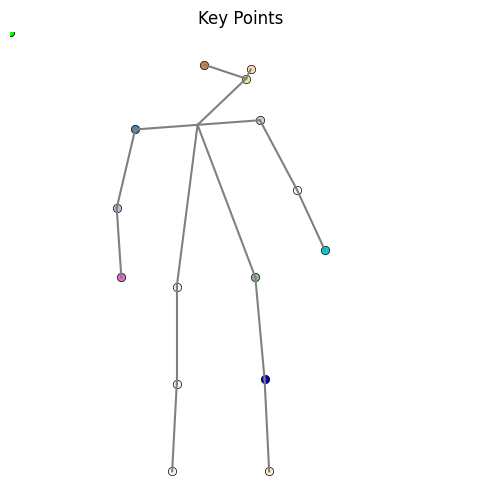

In [ ]:
# Let's take a look at the resulting skeleton
img_with_keypoints(blanc_path, keypoint_locations, legend=False, body=True)

In [ ]:
  if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument("--folder", type=str,  default="generation_samples", help="root folder for output")

    parser.add_argument("--batch_size", type=int, default=5, help="")
    parser.add_argument("--no_plms", action='store_true', help="use DDIM instead. WARNING: I did not test the code yet")
    parser.add_argument("--guidance_scale", type=float,  default=7.5, help="")
    parser.add_argument("--negative_prompt", type=str,  default='longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality', help="")

    args, unknown = parser.parse_known_args()

    meta = dict(
            ckpt = os.getcwd() + "/gligen_checkpoints/checkpoint_generation_keypoint.pth",
            prompt = "A woman astronaut on the Moon", # "Two Martians are standing in a wasteland. One of them waves his hand.",
            locations = keypoint_locations,
            alpha_type = [0.3, 0.0, 0.7],
            save_folder_name="keypoint"
        )

    starting_noise = torch.randn(args.batch_size, 4, 64, 64).to(device)
    starting_noise = None

    run(meta, args, starting_noise)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.encoder.layers.5.self_attn.q_proj.weight', 'vision_model.post_layernorm.bias', 'vision_model.encoder.layers.14.mlp.fc2.weight', 'vision_model.encoder.layers.15.mlp.fc1.weight', 'vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_model.encoder.layers.4.mlp.fc2.bias', 'vision_model.encoder.layers.13.layer_norm2.weight', 'vision_model.encoder.layers.4.layer_norm1.weight', 'vision_model.encoder.layers.1.self_attn.k_proj.weight', 'vision_model.encoder.layers.5.layer_norm2.weight', 'vision_model.encoder.layers.14.self_attn.out_proj.bias', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.16.mlp.fc2.weight', 'vision_model.encoder.layers.14.layer_norm1.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.self_attn.out_proj.bi

[5, 6, 7, 8, 9]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


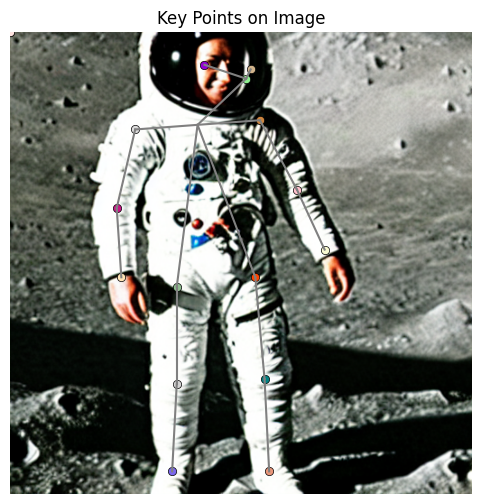

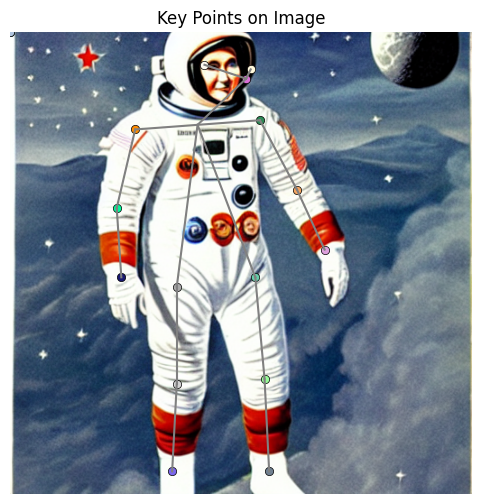

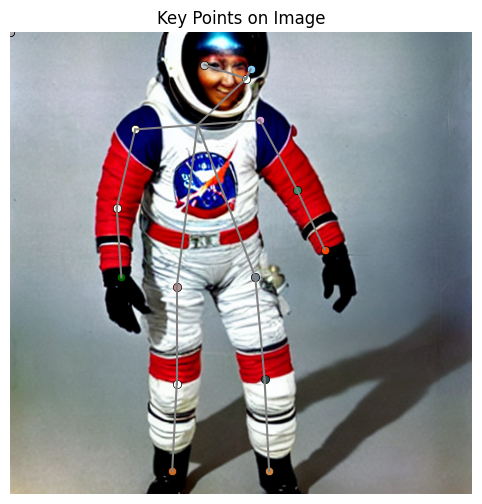

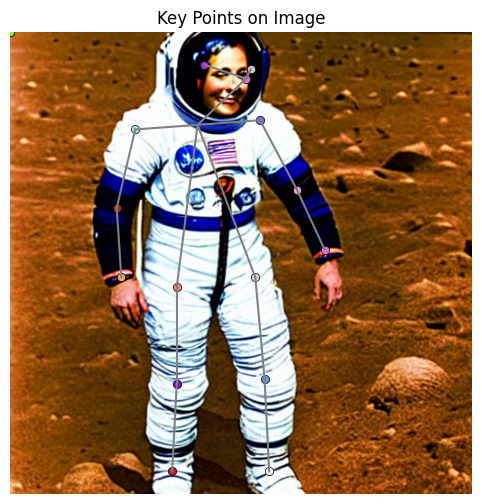

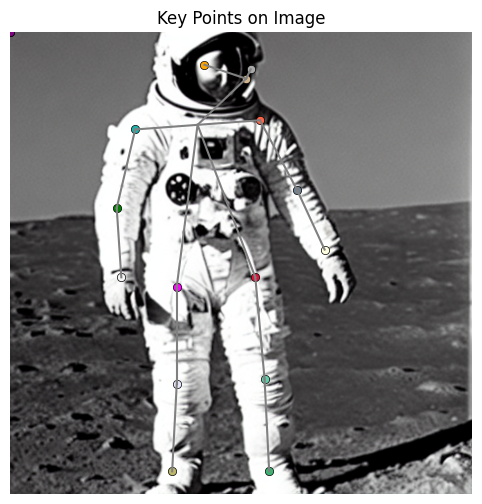

In [ ]:
for i in range(5):
  img_with_keypoints(os.getcwd() + f'/generation_samples/keypoint/{i}.png', keypoint_locations, legend=False, body=True)